# Prediction Results on Summary Vectronics Data

**Last Modified**: Aug 20, 2025

In this notebook, we summarize and visualize the results for behavior classification with audio annotations on summary sttaistics of Vectronics acceleration data. The training and testing data splits are created randomly for this experiment. We conduct hyperparameter tuning and look at the prediction results f the best performing model.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import yaml
import sys
from tqdm import tqdm
import json
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from dataclasses import dataclass, field
from typing import  List
from torch.utils.data import DataLoader
sys.path.append('.')
sys.path.append('../')

from src.utils.data_prep import (setup_multilabel_dataloaders,)

from src.utils.train import (train_run, standard_training_epoch)
from src.utils.plots import (multi_label_predictions)

from src.methods.prediction_model import (SimpleFeatureNet)
from src.utils.datasets import (NumpyDataset)
from src.utils.io import (get_metadata_path,
                          get_results_dir,

                          )
from src.utils import preprocess
import src.utils.io as io
from src.utils.Vectronics_preprocessing import (load_annotations,
                                                load_Vectronics_data_metadata,
                                                create_max_windows,
                                                create_data_splits,
                                                create_summary_data)
from src.utils.functionalities import(mmd_test,
                                      median_pairwise_distance,
                                      set_seed)
from scripts.run_Vectronics_preprocessing import smooth_behavior_segments
import config as config
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


In [3]:
# Graphing Parameters
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
mpl.rcParams["axes.labelsize"] = 25
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['text.usetex'] = True

In [24]:
# load matched acceleration and label pairs data, metadata, and summary

all_annotations = load_annotations()
smoothed_all_annotations = smooth_behavior_segments(all_annotations)
# all_annotations = all_annotations[all_annotations['Confidence (H-M-L)'].isin(['H', 'H/M'])]

/home/medhaaga/BotswanaML/notebooks/../scripts/run_Vectronics_preprocessing.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prev.Timestamp_end = row.Timestamp_end
/home/medhaaga/BotswanaML/notebooks/../scripts/run_Vectronics_preprocessing.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prev.duration = (
/home/medhaaga/BotswanaML/notebooks/../scripts/run_Vectronics_preprocessing.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

In [5]:
values = [15, 30]
quantiles = [np.mean(all_annotations["duration"] <= value) for value in values]
for value, q in zip(values, quantiles):
    print(f"Value {value}s is approximately at the {q:.2f}th percentile.")

Value 15s is approximately at the 0.63th percentile.
Value 30s is approximately at the 0.79th percentile.


In [19]:
# Group and sum durations in hours
duration_table = np.round(all_annotations.groupby(['Source', 'Behavior'])['duration'].sum().div(3600), 4)

# Convert to a pivot table: behaviors as rows, sources as columns
duration_df = duration_table.unstack(fill_value=0)

# Add a row for total duration per source
duration_df.loc['Total'] = duration_df.sum()

print("DURATION SUMMARY FOR ANNOTATIONS")
print(duration_df)

DURATION SUMMARY FOR ANNOTATIONS
Behavior  Feeding   Moving   Other  Running  Stationary
Source                                                 
Audio      2.6872   9.2189  0.6900   5.4644      0.0431
Video      1.4911   3.6947  1.2767   0.1722     80.8658
Total      4.1783  12.9136  1.9667   5.6366     80.9089


In [37]:
# load metadata, matched acceleration data, and matched acceleration metadata
acc_data, acc_data_metadata = load_Vectronics_data_metadata()

# Group and sum durations in hours
duration_table = np.round(acc_data.groupby(['Source', 'behavior'])['duration'].sum().div(3600), 4)

# Convert to a pivot table: behaviors as rows, sources as columns
duration_df = duration_table.unstack(fill_value=0)

# Add a row for total duration per source
duration_df.loc['Total'] = duration_df.sum()

print("DURATION SUMMARY FOR MATCHED ANNOTATIONS")
print(duration_df)

DURATION SUMMARY FOR MATCHED ANNOTATIONS
behavior  Feeding   Moving   Other  Running  Stationary
Source                                                 
Audio      2.6844   9.1662  0.2327   5.3635      0.0428
Video      1.3825   1.6700  1.0506   0.0936     67.9997
Total      4.0669  10.8362  1.2833   5.4571     68.0425


In [39]:
annotations_summary = pd.read_csv(io.get_matched_annotations_summary_path())
unmatched_audio_labels_duration = annotations_summary[(annotations_summary.match == 0) & (annotations_summary.Source == 'Audio')].dropna().duration.sum()/3600
print(f"TOTAL UNMATCHED AUDIO LABELS: {unmatched_audio_labels_duration} hours")

TOTAL UNMATCHED AUDIO LABELS: 0.0 hours


## 1. Create $X$: Summarize the Vectronics Matched Data

In [27]:
device = torch.device(f"cuda:{1}" if torch.cuda.is_available() else "cpu")
with open(config.VECTRONICS_PREPROCESSING_YAML) as f:
    Vectronics_preprocessing_config = yaml.safe_load(f)
feature_cols = Vectronics_preprocessing_config['feature_cols']
helper_cols = Vectronics_preprocessing_config['helper_cols']

/home/medhaaga/miniconda3/envs/wildlife/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /opt/conda/conda-bld/pytorch_1729647348947/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


First, we see if the distribution of summaries varies when the summaries are calculated over 20 seconds or 30 seconds windows of acceleration data.

In [15]:
window_durations = [20.0, 30.0]
datasets = []
# for instances > window duration, split them into multiple instances

for window_duration in window_durations:
    acc_data_split = create_max_windows(acc_data=acc_data, window_duration=window_duration, sampling_rate=config.SAMPLING_RATE)
    acc_data_split = acc_data_split[acc_data_split.duration >= window_duration]

    # Group and sum durations in hours
    duration_table = acc_data_split.groupby(['Source', 'behavior'])['duration'].sum().div(3600)
    duration_df = duration_table.unstack(fill_value=0)
    duration_df.loc['Total'] = duration_df.sum()

    print(f"Window duration = {window_duration}")
    print(duration_df)

    datasets.append(create_summary_data(acc_data_split, sampling_rate=config.SAMPLING_RATE))
    

Window duration = 20.0
behavior   Feeding    Moving     Other   Running  Stationary
Source                                                      
Audio     2.338889  6.822222  0.000000  4.005556    0.000000
Video     0.927778  0.466667  0.244444  0.038889   55.772222
Total     3.266667  7.288889  0.244444  4.044444   55.772222
Window duration = 30.0
behavior   Feeding  Moving  Other   Running  Stationary
Source                                                 
Audio     2.141667   5.525  0.000  3.291667    0.000000
Video     0.750000   0.225  0.175  0.016667   51.566667
Total     2.891667   5.750  0.175  3.308333   51.566667


In [11]:
Vectronics_df = pd.read_csv(io.get_Vectronics_preprocessed_path(15.0))
duration_table = Vectronics_df.groupby(['Source', 'behavior'])['duration'].sum().div(3600)
duration_df = duration_table.unstack(fill_value=0)
duration_df.loc['Total'] = duration_df.sum()

print(duration_df)

behavior   Feeding    Moving     Other   Running  Stationary
Source                                                      
Audio     2.366667  7.575000  0.600000  4.366667    0.033333
Video     1.158333  1.008333  0.483333  0.066667   58.858333
Total     3.525000  8.583333  1.083333  4.433333   58.891667


In [25]:
np.unique(all_annotations[all_annotations.duration >= 15.0].Behavior.values, return_counts=True)

(array(['Feeding', 'Moving', 'Other', 'Running', 'Stationary'],
       dtype=object),
 array([ 236, 1012,  157,  476, 2914]))

In [16]:
from itertools import combinations

n, m = 5000, 5000
num_permutations = 100
seed = 42
rng = np.random.default_rng(seed)

datasets = {'window_20': datasets[0][feature_cols].values[rng.permutation(len(datasets[0]))],
            'window_30': datasets[1][feature_cols].values[rng.permutation(len(datasets[1]))]
}

for (name1, Xs), (name2, Xt) in combinations(datasets.items(), 2):
    Xs_sub = Xs[:n, :]
    Xt_sub = Xt[:m, :]
    
    sigma = median_pairwise_distance(Xs_sub, Xt_sub)
    stat, permuted_stat, pval = mmd_test(
        X=Xs_sub,
        Y=Xt_sub,
        sigma=sigma,
        num_permutations=num_permutations,
        seed=seed
    )
    
    print(f"\nComparison: {name1} vs {name2}")
    print(f"MMD² statistic: {stat:.4f}")
    if pval < 0.05:
        print(f"P-value: {pval:.4f} - The two distributions are significantly different (reject H₀).")
    else:
        print(f"P-value: {pval:.4f} - The two distributions are not significantly different (fail to reject H₀).")



Comparison: window_20 vs window_30
MMD² statistic: 0.0004
P-value: 0.0600 - The two distributions are not significantly different (fail to reject H₀).


In [20]:
# Load preprocessed Vectronics config

with open(config.VECTRONICS_PREPROCESSING_YAML) as f:
    Vectronics_preprocessing_config = yaml.safe_load(f)

Vectronics_feature_cols = Vectronics_preprocessing_config['feature_cols']
Vectronics_helper_cols = Vectronics_preprocessing_config['helper_cols']
vectronics_df = pd.read_csv(io.get_Vectronics_preprocessed_path(duration=15.0))
vectronics_df = vectronics_df[Vectronics_feature_cols + Vectronics_helper_cols]

duration_table = vectronics_df.groupby(['Source', 'behavior'])['behavior'].count()
duration_df = duration_table.unstack(fill_value=0)
duration_df.loc['Total'] = duration_df.sum()
print(duration_df)

behavior  Feeding  Moving  Other  Running  Stationary
Source                                               
Audio         284     909     72      524           4
Video         139     121     58        8        7063
Total         423    1030    130      532        7067


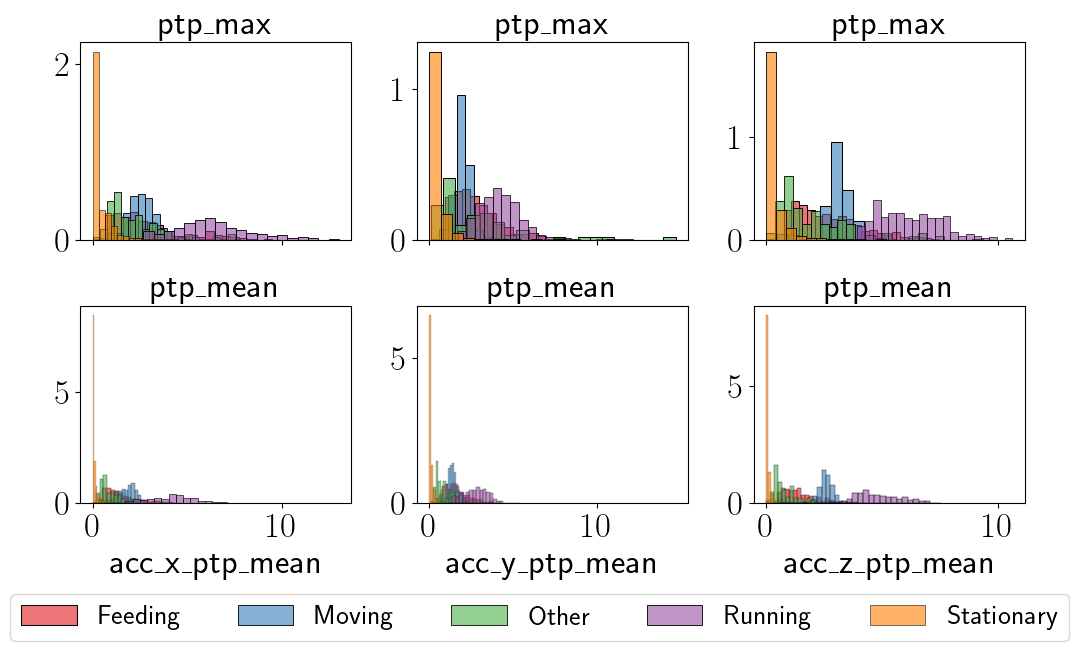

In [54]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharey=False, sharex='col')
palette = sns.color_palette("Set1", n_colors=len(config.SUMMARY_BEHAVIORS))

behaviors_to_plot = vectronics_df['behavior'].unique()
acc_axes = ['acc_x', 'acc_y', 'acc_z']
features = ['ptp_max', 'ptp_mean']

for i, feature in enumerate(features):
    for j, axis in enumerate(acc_axes):

        feature_name = axis + '_' + feature
        ax = axes[i, j]

        for k, behavior in enumerate(config.SUMMARY_BEHAVIORS):
            sns.histplot(
                vectronics_df[vectronics_df['behavior'] == behavior][feature_name],
                label=behavior,
                kde=False,
                ax=ax,
                stat='density',
                bins=20,
                color=palette[k],
                alpha=0.6
            )

        ax.set_title(feature)
        ax.set_title(feature)
        ax.set_ylabel("")

# Place legend outside at the bottom center
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(config.SUMMARY_BEHAVIORS), bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.show()

In [33]:
vectronics_df = pd.read_csv(io.get_Vectronics_preprocessed_path(duration=15.0))
np.unique(vectronics_df.behavior.values, return_counts=True)

(array(['Feeding', 'Moving', 'Other', 'Running', 'Stationary'],
       dtype=object),
 array([ 423, 1030,  130,  532, 7067]))

## 2. Predict $Y \mid X$: Train Classification Model

In [21]:
vectronics_df = pd.read_csv(io.get_Vectronics_preprocessed_path(duration=15.0))
X_src = vectronics_df[Vectronics_feature_cols].values

# compute global lows/highs once
lows, highs = preprocess.compute_combined_quantiles(
    datasets=[X_src],
    pos_idx=[0,1,2,3,4,5],
    center_idx=None,
    low_q=0.00,
    high_q=1.00,
)

# define transform
transform = preprocess.TransformAndScale(
    pos_idx=[0,1,2,3,4,5],
    center_idx=None,
    lows=lows,
    highs=highs,
    clip_to_quantile=False
)


In [22]:
label_encoder = LabelEncoder()
label_encoder.fit(config.SUMMARY_BEHAVIORS)

training_results_dir = os.path.join(get_results_dir(), 'summary_training_results')
os.makedirs(training_results_dir, exist_ok=True)

In [23]:
# train and model arguments

@dataclass
class Args:
    batch_size: int = 512
    num_epochs: int = 100
    theta: float = 0.5
    learning_rate: float = 0.001
    weight_decay: float = 0.0
    print_freq: int = 10
    verbose: bool = False
    seed: int= 1
    test_frac: float = 0.2
    val_frac: float = 0.2
    hidden_layers: List[int] = field(default_factory=lambda: [64, 128])
    dropout_rate: float = 0.5    

args = Args()

#### 2.1 All Feeding Labels + Mullti-label Classification

In [24]:
vectronics_df = pd.read_csv(io.get_Vectronics_preprocessed_path(duration=15.0))
vectronics_df = vectronics_df[Vectronics_feature_cols + Vectronics_helper_cols]

duration_table = vectronics_df.groupby(['Source', 'behavior'])['behavior'].count()
duration_df = duration_table.unstack(fill_value=0)
duration_df.loc['Total'] = duration_df.sum()
print(duration_df)

dir = os.path.join(training_results_dir, 'all_feeding')
os.makedirs(dir, exist_ok=True)

behavior  Feeding  Moving  Other  Running  Stationary
Source                                               
Audio         284     909     72      524           4
Video         139     121     58        8        7063
Total         423    1030    130      532        7067


In [25]:
X_src = vectronics_df[Vectronics_feature_cols].values
y_src = vectronics_df['behavior'].values

# encode the labels
label_encoder = LabelEncoder()
y_src = label_encoder.fit_transform(y_src)
n_classes = len(np.unique(y_src))

# create datasets and dataloaders 
X_train, X_temp, y_train, y_temp = train_test_split(X_src, y_src, test_size=2*args.test_frac, random_state=42, stratify=y_src)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


train_loader, val_loader, test_loader = setup_multilabel_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, args, transform=transform)

X_train: (5509, 6) y_train: (5509,)
X_val: (1836, 6) y_val: (1836,)
X_test: (1837, 6) y_test: (1837,)


In [28]:
theta_list = np.round(0.2 * np.arange(0, 6), 1)
seed_list = [1]

for theta in theta_list:
    for seed in seed_list:

        tqdm.write(f"Current theta: {theta}, Current seed: {seed}")
        args.theta = theta
        args.seed = seed

        set_seed(seed)

        # setup dataloaders
        train_loader, val_loader, test_loader = setup_multilabel_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, args, transform=transform)

        # setup model, loss, and optimizer
        model = SimpleFeatureNet(input_dim=X_train.shape[1], num_classes=len(config.SUMMARY_BEHAVIORS), hidden_layers=args.hidden_layers, dropout_rate=args.dropout_rate).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
        criterion = nn.BCEWithLogitsLoss()

        #### Training
        results = train_run(model, optimizer, criterion, train_loader, val_loader, test_loader,
                                args, device, standard_training_epoch, threshold=0.5)
        
        model_dir = os.path.join(dir, f"theta{args.theta}_seed{args.seed}")
        os.makedirs(model_dir, exist_ok=True)

        model = results['model'].to(device)
        torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))


        json_training_stats_file = os.path.join(model_dir, 'training_stats.json')
        with open(json_training_stats_file, 'w') as f:
            json.dump(results['training_stats'], f, indent=4)

        # Save test results
        test_results_path = os.path.join(model_dir, 'test_results.npz')
        np.savez(
        test_results_path,
        true_classes=results['test_true_classes'],
        predictions=results['test_predictions'],
        scores=results['test_scores'])

        # Save val results
        val_results_path = os.path.join(model_dir, 'val_results.npz')
        np.savez(
            val_results_path,
            true_classes=results['val_true_classes'],
            predictions=results['val_predictions'],
            scores=results['val_scores'])

        

Current theta: 0.0, Current seed: 1


Epoch 100/100 | Train Loss: 0.0273 | Val Loss: 0.0265 | Best Val Loss: 0.0264: 100%|██████████| 100/100 [01:12<00:00,  1.39it/s]


Total training time: 0:01:12
Current theta: 0.2, Current seed: 1


Epoch 100/100 | Train Loss: 0.0407 | Val Loss: 0.0263 | Best Val Loss: 0.0263: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Total training time: 0:01:08
Current theta: 0.4, Current seed: 1


Epoch 100/100 | Train Loss: 0.0515 | Val Loss: 0.0278 | Best Val Loss: 0.0278: 100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Total training time: 0:01:02
Current theta: 0.6, Current seed: 1


Epoch 100/100 | Train Loss: 0.0676 | Val Loss: 0.0318 | Best Val Loss: 0.0318: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


Total training time: 0:01:16
Current theta: 0.8, Current seed: 1


Epoch 100/100 | Train Loss: 0.0724 | Val Loss: 0.0400 | Best Val Loss: 0.0360: 100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


Total training time: 0:01:05
Current theta: 1.0, Current seed: 1


Epoch 100/100 | Train Loss: 0.0780 | Val Loss: 0.0435 | Best Val Loss: 0.0426: 100%|██████████| 100/100 [01:20<00:00,  1.25it/s]

Total training time: 0:01:20


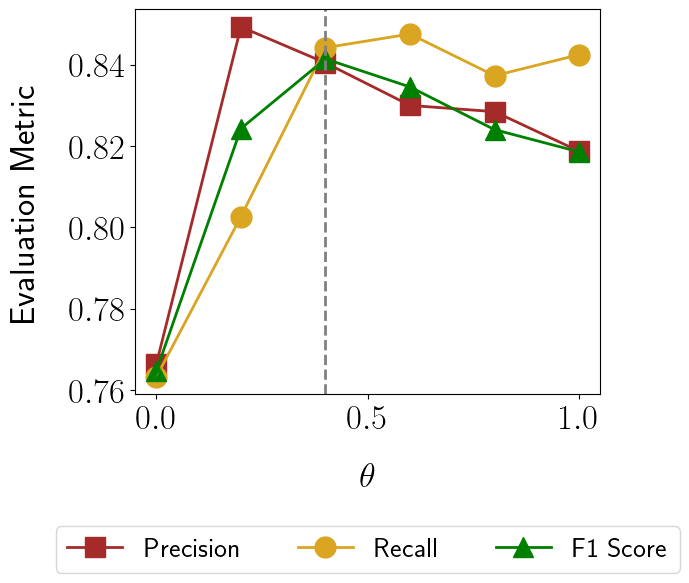

In [29]:
colors = ['brown', 'goldenrod', 'green']
plt.figure(figsize=(6, 5))

precisions, recalls, f1scores = np.zeros((len(theta_list), len(seed_list))), np.zeros((len(theta_list), len(seed_list))), np.zeros((len(theta_list), len(seed_list)))

for j, theta in enumerate(theta_list):
    for k, seed in enumerate(seed_list):

        model_dir = os.path.join(dir, f"theta{theta}_seed{seed}")
        precisions[j,k] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_precision=True)
        recalls[j,k] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_recall=True)
        f1scores[j,k] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_f1=True)

plt.plot(theta_list, np.mean(precisions, axis=-1), color=colors[0], label='Precision', markersize=15, linewidth=2, marker='s',)
plt.plot(theta_list, np.mean(recalls, axis=-1), color=colors[1], label='Recall', markersize=15, linewidth=2, marker='o',)
plt.plot(theta_list, np.mean(f1scores, axis=-1), color=colors[2], label='F1 Score', markersize=15, linewidth=2, marker='^',)

for k in range(len(seed_list)):
    plt.plot(theta_list, precisions[:,k], color=colors[0], linewidth=1, linestyle='--', alpha=0.3)
    plt.plot(theta_list, recalls[:,k], color=colors[1],  linewidth=1, linestyle='--', alpha=0.3)
    plt.plot(theta_list, f1scores[:,k], color=colors[2], linewidth=1, linestyle='--', alpha=0.3)


plt.axvline(x=theta_list[np.argmax(np.mean(f1scores, axis=-1))], linestyle='--', color='grey', linewidth=2,)
plt.xlabel(r'$\theta$', labelpad=20)
plt.ylabel('Evaluation Metric', labelpad=20)

plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5,-0.5))
plt.show()  

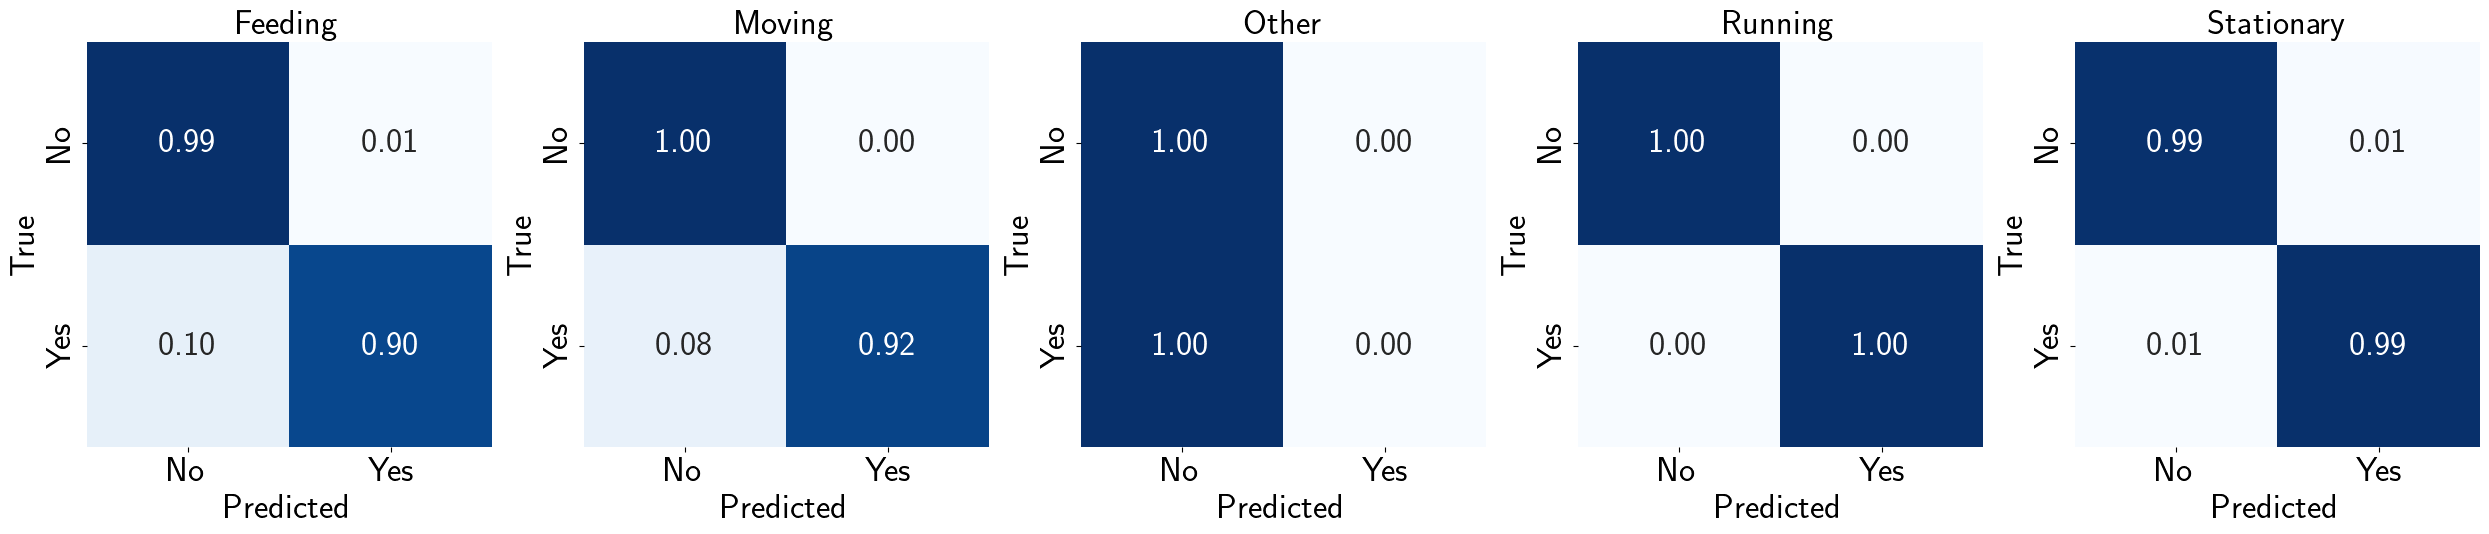

{}

In [30]:
theta_star, seed_star = 0.0, 1
model_dir = os.path.join(dir, f"theta{theta_star}_seed{seed_star}")
multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=True, return_precision=False)

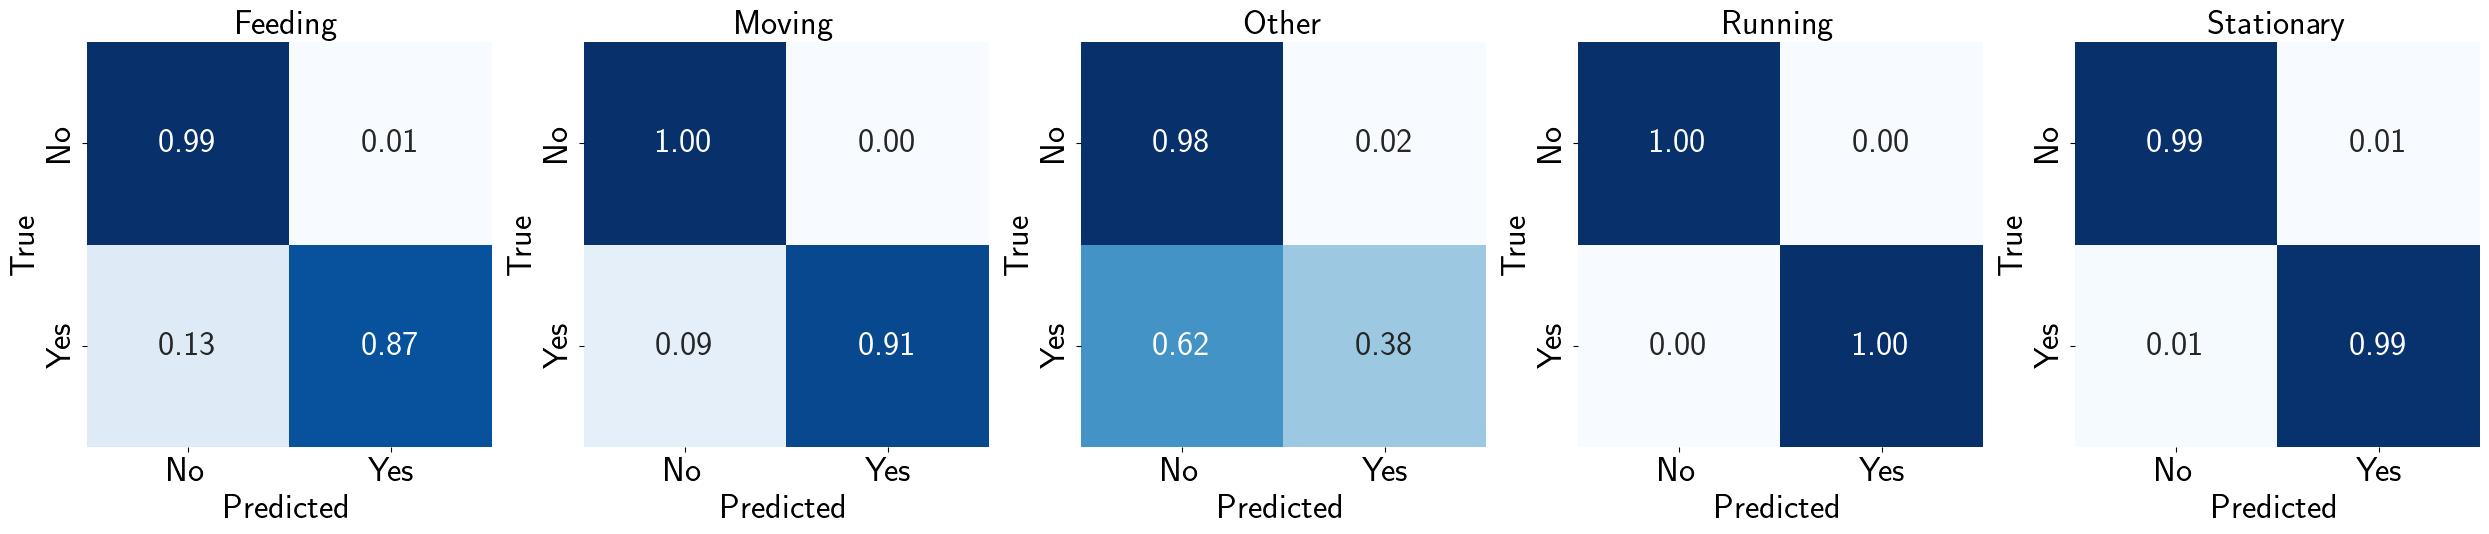

{}

In [31]:
theta_star, seed_star = 0.4, 1
model_dir = os.path.join(dir, f"theta{theta_star}_seed{seed_star}")
multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=True, return_precision=False)

In [32]:
multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=False, return_accuracy=True)

0.9635274904735982

#### 2.2 All Feeding Labels + Binary Classification

In [33]:
dir = os.path.join(training_results_dir, 'all_feeding_binary_classification')
os.makedirs(dir, exist_ok=True)

In [34]:
# Map original string labels to binary
y_binary = np.array([lbl if lbl == 'Feeding' else 'Other' for lbl in vectronics_df['behavior'].values])

# encode the labels
label_encoder = LabelEncoder()
y_binary = label_encoder.fit_transform(y_binary)
n_classes = len(np.unique(y_binary))

print("Number of Feeding samples:", (y_binary == 0).sum())

X_train, X_temp, y_train, y_temp = train_test_split(X_src, y_binary, test_size=2*args.test_frac, random_state=42, stratify=y_binary)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

train_loader, val_loader, test_loader = setup_multilabel_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, args, transform=transform)

Number of Feeding samples: 423
X_train: (5509, 6) y_train: (5509,)
X_val: (1836, 6) y_val: (1836,)
X_test: (1837, 6) y_test: (1837,)


In [35]:
theta_list = np.round(0.2 * np.arange(0, 6), 1)
seed_list = [1]

for theta in theta_list:
    for seed in seed_list:

        tqdm.write(f"Current theta: {theta}, Current seed: {seed}")
        args.theta = theta
        args.seed = seed

        set_seed(seed)

        # setup dataloaders
        train_loader, val_loader, test_loader = setup_multilabel_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, args, transform=transform)
        model = SimpleFeatureNet(input_dim=X_train.shape[1], num_classes=n_classes, hidden_layers=args.hidden_layers, dropout_rate=args.dropout_rate).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
        criterion = nn.BCEWithLogitsLoss()

        #### Training
        results = train_run(model, optimizer, criterion, train_loader, val_loader, test_loader,
                                args, device, standard_training_epoch, threshold=0.5)

        model_dir = os.path.join(dir, f"theta{args.theta}_seed{args.seed}")
        os.makedirs(model_dir, exist_ok=True)

        model = results['model'].to(device)
        torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

        json_training_stats_file = os.path.join(model_dir, 'training_stats.json')
        with open(json_training_stats_file, 'w') as f:
            json.dump(results['training_stats'], f, indent=4)

        # Save test results
        test_results_path = os.path.join(model_dir, 'test_results.npz')
        np.savez(
        test_results_path,
        true_classes=results['test_true_classes'],
        predictions=results['test_predictions'],
        scores=results['test_scores'])

        # Save val results
        val_results_path = os.path.join(model_dir, 'val_results.npz')
        np.savez(
            val_results_path,
            true_classes=results['val_true_classes'],
            predictions=results['val_predictions'],
            scores=results['val_scores'])

Current theta: 0.0, Current seed: 1


Epoch 64/100 | Train Loss: 0.0211 | Val Loss: 0.0257 | Best Val Loss: 0.0256:  64%|██████▍   | 64/100 [00:50<00:27,  1.31it/s]

Epoch 100/100 | Train Loss: 0.0165 | Val Loss: 0.0233 | Best Val Loss: 0.0233: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s]


Total training time: 0:01:18
Current theta: 0.2, Current seed: 1


Epoch 100/100 | Train Loss: 0.0276 | Val Loss: 0.0251 | Best Val Loss: 0.0251: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


Total training time: 0:01:06
Current theta: 0.4, Current seed: 1


Epoch 100/100 | Train Loss: 0.0276 | Val Loss: 0.0313 | Best Val Loss: 0.0284: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


Total training time: 0:01:06
Current theta: 0.6, Current seed: 1


Epoch 100/100 | Train Loss: 0.0226 | Val Loss: 0.0340 | Best Val Loss: 0.0290: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


Total training time: 0:01:12
Current theta: 0.8, Current seed: 1


Epoch 100/100 | Train Loss: 0.0209 | Val Loss: 0.0397 | Best Val Loss: 0.0320: 100%|██████████| 100/100 [01:04<00:00,  1.54it/s]


Total training time: 0:01:05
Current theta: 1.0, Current seed: 1


Epoch 100/100 | Train Loss: 0.0253 | Val Loss: 0.0373 | Best Val Loss: 0.0372: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s]

Total training time: 0:01:13


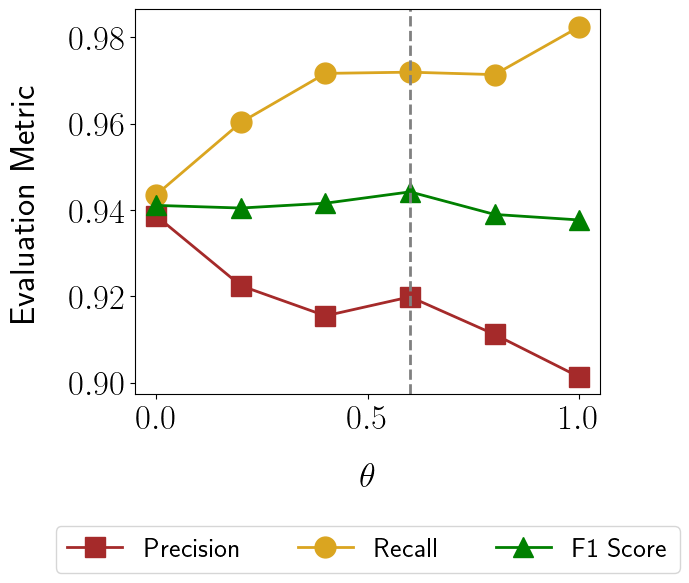

In [36]:
colors = ['brown', 'goldenrod', 'green']
plt.figure(figsize=(6, 5))

precisions, recalls, f1scores = np.zeros((len(theta_list), len(seed_list))), np.zeros((len(theta_list), len(seed_list))), np.zeros((len(theta_list), len(seed_list)))

for j, theta in enumerate(theta_list):
    for k, seed in enumerate(seed_list):

        model_dir = os.path.join(dir, f"theta{theta}_seed{seed}")
        precisions[j,k] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_precision=True)
        recalls[j,k] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_recall=True)
        f1scores[j,k] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_f1=True)

plt.plot(theta_list, np.mean(precisions, axis=-1), color=colors[0], label='Precision', markersize=15, linewidth=2, marker='s',)
plt.plot(theta_list, np.mean(recalls, axis=-1), color=colors[1], label='Recall', markersize=15, linewidth=2, marker='o',)
plt.plot(theta_list, np.mean(f1scores, axis=-1), color=colors[2], label='F1 Score', markersize=15, linewidth=2, marker='^',)

for k in range(len(seed_list)):
    plt.plot(theta_list, precisions[:,k], color=colors[0], linewidth=1, linestyle='--', alpha=0.3)
    plt.plot(theta_list, recalls[:,k], color=colors[1],  linewidth=1, linestyle='--', alpha=0.3)
    plt.plot(theta_list, f1scores[:,k], color=colors[2], linewidth=1, linestyle='--', alpha=0.3)


plt.axvline(x=theta_list[np.argmax(np.mean(f1scores, axis=-1))], linestyle='--', color='grey', linewidth=2,)
plt.xlabel(r'$\theta$', labelpad=20)
plt.ylabel('Evaluation Metric', labelpad=20)

plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5,-0.5))
plt.show()  

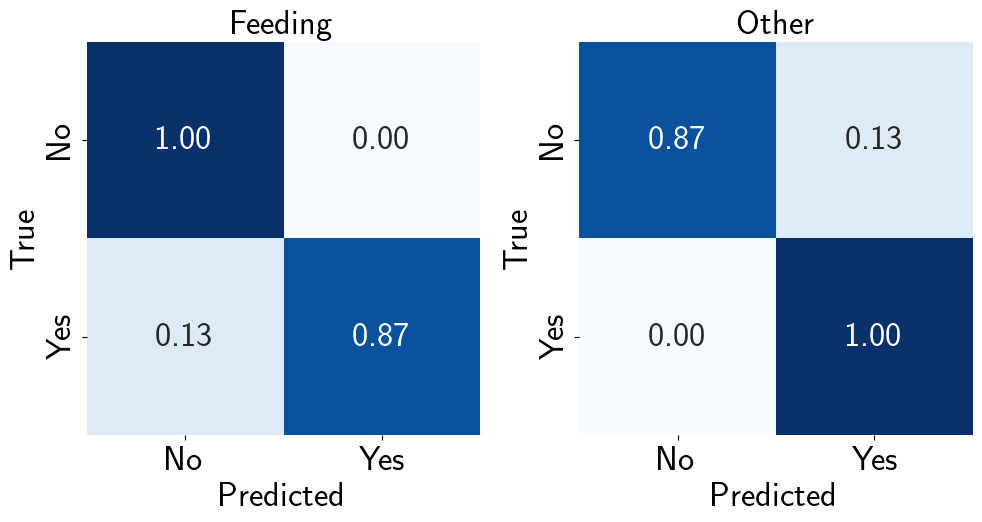

{}

In [37]:
theta_star, seed_star = 0.0, 1
model_dir = os.path.join(dir, f"theta{theta_star}_seed{seed_star}")
multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=True, return_precision=False)

In [38]:
multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=False, return_accuracy=True)

0.9907457811649428

#### 2.2 High Intensity Feeding Labels

In [39]:
dir = os.path.join(training_results_dir, 'high_intensity_feeding')
os.makedirs(dir, exist_ok=True)

In [40]:
vectronics_df['behavior'] = vectronics_df.apply(
                lambda row: (
                    'Other' if (pd.notna(row['Eating intensity']) and row['Eating intensity'] in ['M', 'L'])
                    else row['behavior']
                ),
                axis=1
            )

duration_table = vectronics_df.groupby(['Source', 'behavior'])['behavior'].count()
duration_df = duration_table.unstack(fill_value=0)
duration_df.loc['Total'] = duration_df.sum()
print(duration_df)


behavior  Feeding  Moving  Other  Running  Stationary
Source                                               
Audio         105     909    251      524           4
Video          34     121    163        8        7063
Total         139    1030    414      532        7067


In [41]:
X_src = vectronics_df[Vectronics_feature_cols].values
y_src = vectronics_df['behavior'].values

# encode the labels
label_encoder = LabelEncoder()
y_src = label_encoder.fit_transform(y_src)
n_classes = len(np.unique(y_src))

# create datasets and dataloaders 

# compute global lows/highs once
lows, highs = preprocess.compute_combined_quantiles(
    datasets=[X_src],
    pos_idx=[0,1,2,3,4,5],
    center_idx=None,
    low_q=0.00,
    high_q=1.00,
)

# define transform
transform = preprocess.TransformAndScale(
    pos_idx=[0,1,2,3,4,5],
    center_idx=None,
    lows=lows,
    highs=highs,
    clip_to_quantile=False
)

X_train, X_temp, y_train, y_temp = train_test_split(X_src, y_src, test_size=2*args.test_frac, random_state=42, stratify=y_src)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

train_loader, val_loader, test_loader = setup_multilabel_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, args, transform=transform)

X_train: (5509, 6) y_train: (5509,)
X_val: (1836, 6) y_val: (1836,)
X_test: (1837, 6) y_test: (1837,)


In [42]:
theta_list = np.round(0.2 * np.arange(0, 6), 1)
seed_list = [1]

for theta in theta_list:
    for seed in seed_list:

        tqdm.write(f"Current theta: {theta}, Current seed: {seed}")
        args.theta = theta
        args.seed = seed

        set_seed(seed)

        # setup dataloaders
        train_loader, val_loader, test_loader = setup_multilabel_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, args, transform=transform)

        # setup model, loss, and optimizer
        model = SimpleFeatureNet(input_dim=X_train.shape[1], num_classes=len(config.SUMMARY_BEHAVIORS), hidden_layers=args.hidden_layers, dropout_rate=args.dropout_rate).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
        criterion = nn.BCEWithLogitsLoss()

        #### Training
        results = train_run(model, optimizer, criterion, train_loader, val_loader, test_loader,
                                args, device, standard_training_epoch, threshold=0.5)
        
        model_dir = os.path.join(dir, f"theta{args.theta}_seed{args.seed}")
        os.makedirs(model_dir, exist_ok=True)

        model = results['model'].to(device)
        torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))


        json_training_stats_file = os.path.join(model_dir, 'training_stats.json')
        with open(json_training_stats_file, 'w') as f:
            json.dump(results['training_stats'], f, indent=4)

        # Save test results
        test_results_path = os.path.join(model_dir, 'test_results.npz')
        np.savez(
        test_results_path,
        true_classes=results['test_true_classes'],
        predictions=results['test_predictions'],
        scores=results['test_scores'])

        # Save val results
        val_results_path = os.path.join(model_dir, 'val_results.npz')
        np.savez(
            val_results_path,
            true_classes=results['val_true_classes'],
            predictions=results['val_predictions'],
            scores=results['val_scores'])

        

Current theta: 0.0, Current seed: 1


Epoch 74/100 | Train Loss: 0.0243 | Val Loss: 0.0259 | Best Val Loss: 0.0259:  74%|███████▍  | 74/100 [00:51<00:17,  1.52it/s]

Epoch 100/100 | Train Loss: 0.0218 | Val Loss: 0.0246 | Best Val Loss: 0.0245: 100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


Total training time: 0:01:08
Current theta: 0.2, Current seed: 1


Epoch 100/100 | Train Loss: 0.0308 | Val Loss: 0.0241 | Best Val Loss: 0.0241: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


Total training time: 0:01:18
Current theta: 0.4, Current seed: 1


Epoch 100/100 | Train Loss: 0.0384 | Val Loss: 0.0244 | Best Val Loss: 0.0241: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Total training time: 0:01:12
Current theta: 0.6, Current seed: 1


Epoch 100/100 | Train Loss: 0.0496 | Val Loss: 0.0255 | Best Val Loss: 0.0246: 100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Total training time: 0:01:02
Current theta: 0.8, Current seed: 1


Epoch 100/100 | Train Loss: 0.0548 | Val Loss: 0.0275 | Best Val Loss: 0.0259: 100%|██████████| 100/100 [01:08<00:00,  1.45it/s]


Total training time: 0:01:09
Current theta: 1.0, Current seed: 1


Epoch 100/100 | Train Loss: 0.0658 | Val Loss: 0.0308 | Best Val Loss: 0.0297: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]

Total training time: 0:01:08


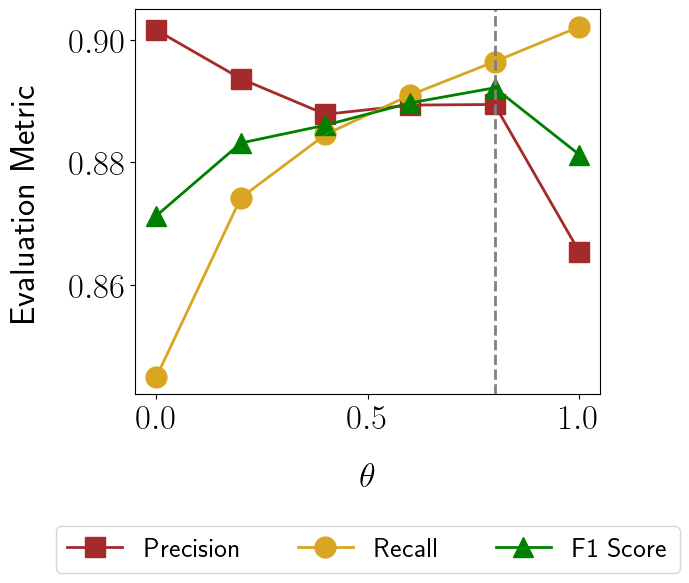

In [43]:
colors = ['brown', 'goldenrod', 'green']
plt.figure(figsize=(6, 5))

precisions, recalls, f1scores = np.zeros((len(theta_list), len(seed_list))), np.zeros((len(theta_list), len(seed_list))), np.zeros((len(theta_list), len(seed_list)))

for j, theta in enumerate(theta_list):
    for k, seed in enumerate(seed_list):

        model_dir = os.path.join(dir, f"theta{theta}_seed{seed}")
        precisions[j,k] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_precision=True)
        recalls[j,k] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_recall=True)
        f1scores[j,k] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_f1=True)

plt.plot(theta_list, np.mean(precisions, axis=-1), color=colors[0], label='Precision', markersize=15, linewidth=2, marker='s',)
plt.plot(theta_list, np.mean(recalls, axis=-1), color=colors[1], label='Recall', markersize=15, linewidth=2, marker='o',)
plt.plot(theta_list, np.mean(f1scores, axis=-1), color=colors[2], label='F1 Score', markersize=15, linewidth=2, marker='^',)

for k in range(len(seed_list)):
    plt.plot(theta_list, precisions[:,k], color=colors[0], linewidth=1, linestyle='--', alpha=0.3)
    plt.plot(theta_list, recalls[:,k], color=colors[1],  linewidth=1, linestyle='--', alpha=0.3)
    plt.plot(theta_list, f1scores[:,k], color=colors[2], linewidth=1, linestyle='--', alpha=0.3)


plt.axvline(x=theta_list[np.argmax(np.mean(f1scores, axis=-1))], linestyle='--', color='grey', linewidth=2,)
plt.xlabel(r'$\theta$', labelpad=20)
plt.ylabel('Evaluation Metric', labelpad=20)

plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5,-0.5))
plt.show()  

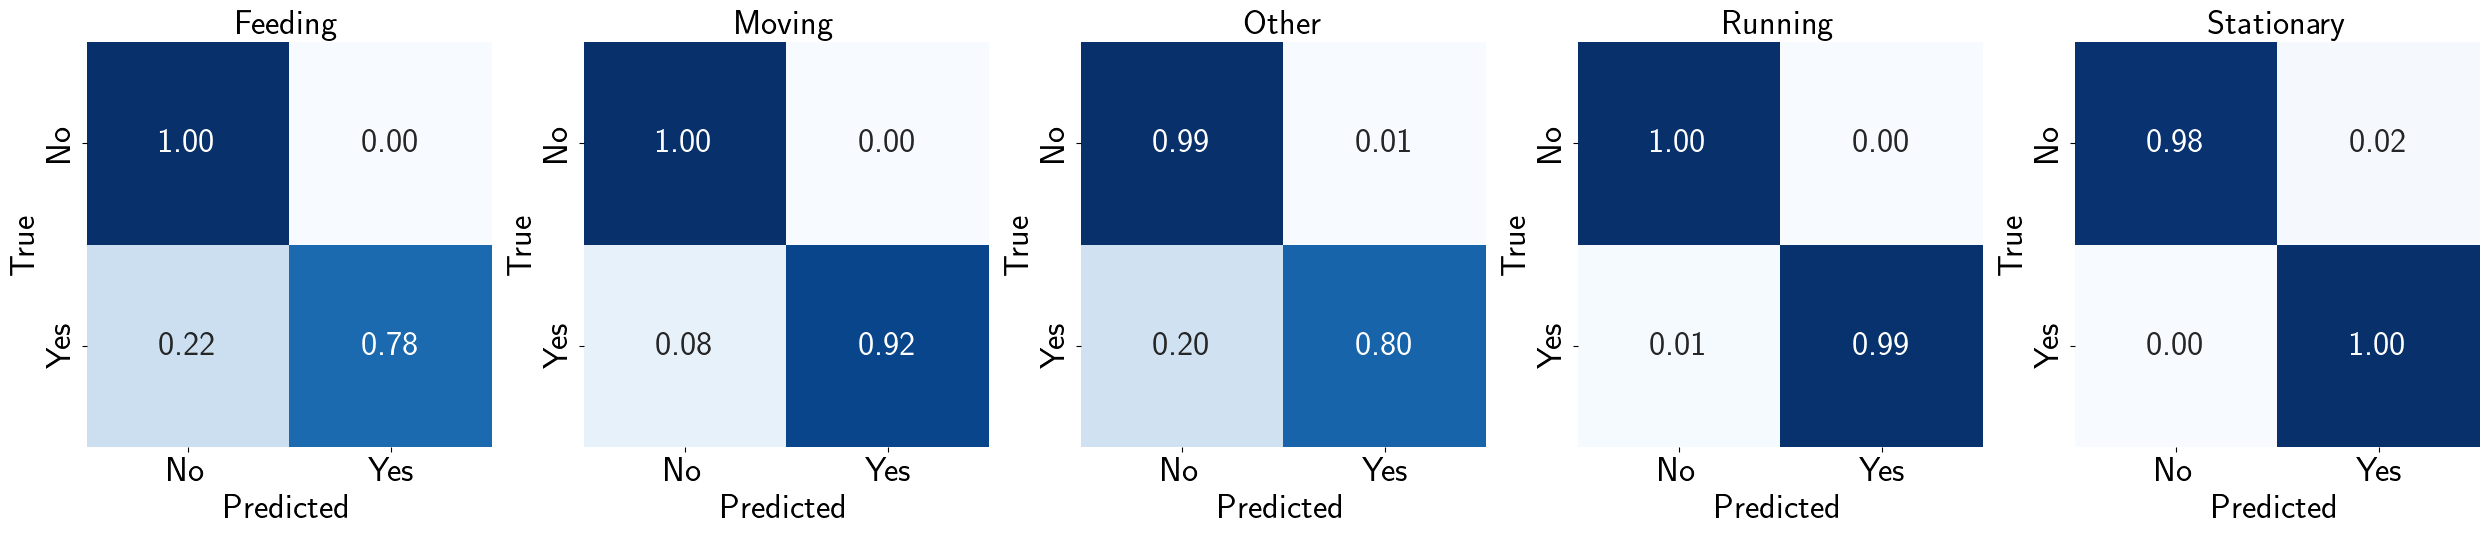

{}

In [44]:
theta_star, seed_star = 0.0, 1
model_dir = os.path.join(dir, f"theta{theta_star}_seed{seed_star}")
multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=True, return_precision=False)

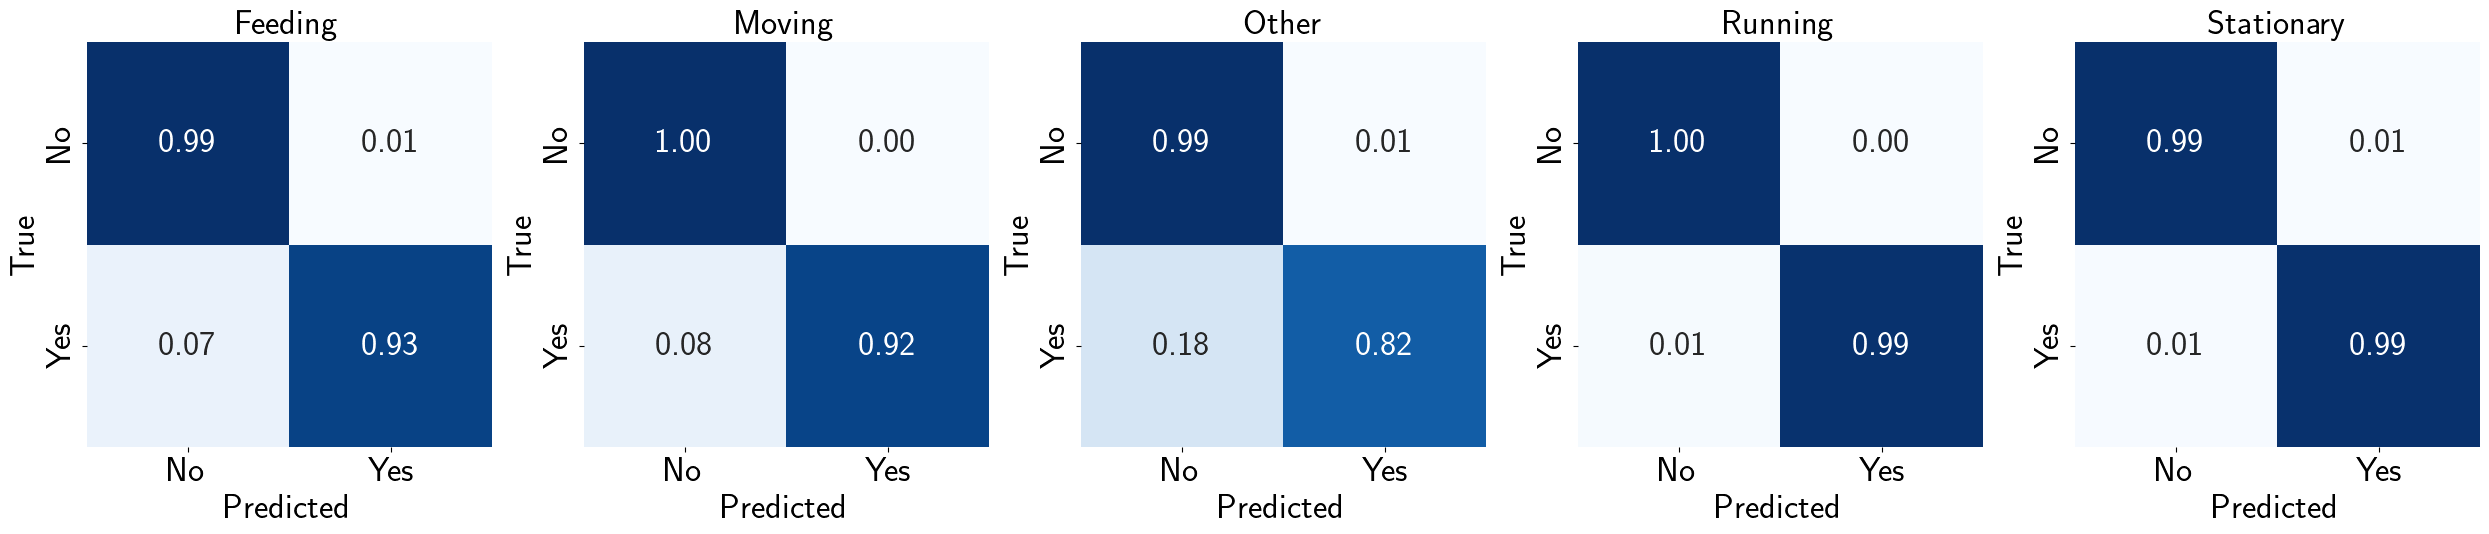

{}

In [45]:
theta_star, seed_star = 0.6, 1
model_dir = os.path.join(dir, f"theta{theta_star}_seed{seed_star}")
multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=True, return_precision=False)

In [46]:
multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=False, return_accuracy=True)


0.9700598802395209

#### 2.3 High Intensity Feeding + BInary Classification

In [47]:
dir = os.path.join(training_results_dir, 'high_intensity_feeding_binary_classification')
os.makedirs(dir, exist_ok=True)

In [48]:
# Map original string labels to binary
y_binary = np.array([lbl if lbl == 'Feeding' else 'Other' for lbl in vectronics_df['behavior'].values])

# encode the labels
label_encoder = LabelEncoder()
y_binary = label_encoder.fit_transform(y_binary)
n_classes = len(np.unique(y_binary))

print("Number of Feeding samples:", (y_binary == 0).sum())

X_train, X_temp, y_train, y_temp = train_test_split(X_src, y_binary, test_size=2*args.test_frac, random_state=42, stratify=y_binary)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

train_loader, val_loader, test_loader = setup_multilabel_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, args, transform=transform)

Number of Feeding samples: 139
X_train: (5509, 6) y_train: (5509,)
X_val: (1836, 6) y_val: (1836,)
X_test: (1837, 6) y_test: (1837,)


In [49]:
theta_list = np.round(0.2 * np.arange(0, 6), 1)
seed_list = [1]

for theta in theta_list:
    for seed in seed_list:

        tqdm.write(f"Current theta: {theta}, Current seed: {seed}")
        args.theta = theta
        args.seed = seed

        set_seed(seed)

        # setup dataloaders
        train_loader, val_loader, test_loader = setup_multilabel_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, args, transform=transform)
        model = SimpleFeatureNet(input_dim=X_train.shape[1], num_classes=n_classes, hidden_layers=args.hidden_layers, dropout_rate=args.dropout_rate).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
        criterion = nn.BCEWithLogitsLoss()

        #### Training
        results = train_run(model, optimizer, criterion, train_loader, val_loader, test_loader,
                                args, device, standard_training_epoch, threshold=0.5)

        model_dir = os.path.join(dir, f"theta{args.theta}_seed{args.seed}")
        os.makedirs(model_dir, exist_ok=True)

        model = results['model'].to(device)
        torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

        json_training_stats_file = os.path.join(model_dir, 'training_stats.json')
        with open(json_training_stats_file, 'w') as f:
            json.dump(results['training_stats'], f, indent=4)

        # Save test results
        test_results_path = os.path.join(model_dir, 'test_results.npz')
        np.savez(
        test_results_path,
        true_classes=results['test_true_classes'],
        predictions=results['test_predictions'],
        scores=results['test_scores'])

        # Save val results
        val_results_path = os.path.join(model_dir, 'val_results.npz')
        np.savez(
            val_results_path,
            true_classes=results['val_true_classes'],
            predictions=results['val_predictions'],
            scores=results['val_scores'])

Current theta: 0.0, Current seed: 1


Epoch 100/100 | Train Loss: 0.0110 | Val Loss: 0.0196 | Best Val Loss: 0.0187: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


Total training time: 0:01:10
Current theta: 0.2, Current seed: 1


Epoch 100/100 | Train Loss: 0.0258 | Val Loss: 0.0335 | Best Val Loss: 0.0311: 100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


Total training time: 0:01:03
Current theta: 0.4, Current seed: 1


Epoch 100/100 | Train Loss: 0.0255 | Val Loss: 0.0455 | Best Val Loss: 0.0397: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


Total training time: 0:01:13
Current theta: 0.6, Current seed: 1


Epoch 100/100 | Train Loss: 0.0308 | Val Loss: 0.0500 | Best Val Loss: 0.0466: 100%|██████████| 100/100 [01:04<00:00,  1.56it/s]


Total training time: 0:01:04
Current theta: 0.8, Current seed: 1


Epoch 100/100 | Train Loss: 0.0182 | Val Loss: 0.0574 | Best Val Loss: 0.0515: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


Total training time: 0:01:08
Current theta: 1.0, Current seed: 1


Epoch 100/100 | Train Loss: 0.0301 | Val Loss: 0.0559 | Best Val Loss: 0.0552: 100%|██████████| 100/100 [01:01<00:00,  1.62it/s]

Total training time: 0:01:02


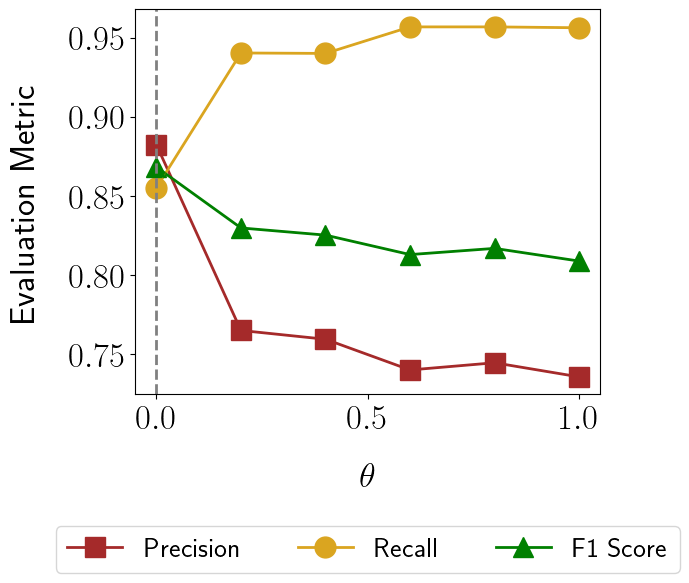

In [50]:
colors = ['brown', 'goldenrod', 'green']
plt.figure(figsize=(6, 5))

precisions, recalls, f1scores = np.zeros((len(theta_list), len(seed_list))), np.zeros((len(theta_list), len(seed_list))), np.zeros((len(theta_list), len(seed_list)))

for j, theta in enumerate(theta_list):
    for k, seed in enumerate(seed_list):

        model_dir = os.path.join(dir, f"theta{theta}_seed{seed}")
        precisions[j,k] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_precision=True)
        recalls[j,k] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_recall=True)
        f1scores[j,k] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_f1=True)

plt.plot(theta_list, np.mean(precisions, axis=-1), color=colors[0], label='Precision', markersize=15, linewidth=2, marker='s',)
plt.plot(theta_list, np.mean(recalls, axis=-1), color=colors[1], label='Recall', markersize=15, linewidth=2, marker='o',)
plt.plot(theta_list, np.mean(f1scores, axis=-1), color=colors[2], label='F1 Score', markersize=15, linewidth=2, marker='^',)

for k in range(len(seed_list)):
    plt.plot(theta_list, precisions[:,k], color=colors[0], linewidth=1, linestyle='--', alpha=0.3)
    plt.plot(theta_list, recalls[:,k], color=colors[1],  linewidth=1, linestyle='--', alpha=0.3)
    plt.plot(theta_list, f1scores[:,k], color=colors[2], linewidth=1, linestyle='--', alpha=0.3)


plt.axvline(x=theta_list[np.argmax(np.mean(f1scores, axis=-1))], linestyle='--', color='grey', linewidth=2,)
plt.xlabel(r'$\theta$', labelpad=20)
plt.ylabel('Evaluation Metric', labelpad=20)

plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5,-0.5))
plt.show()  

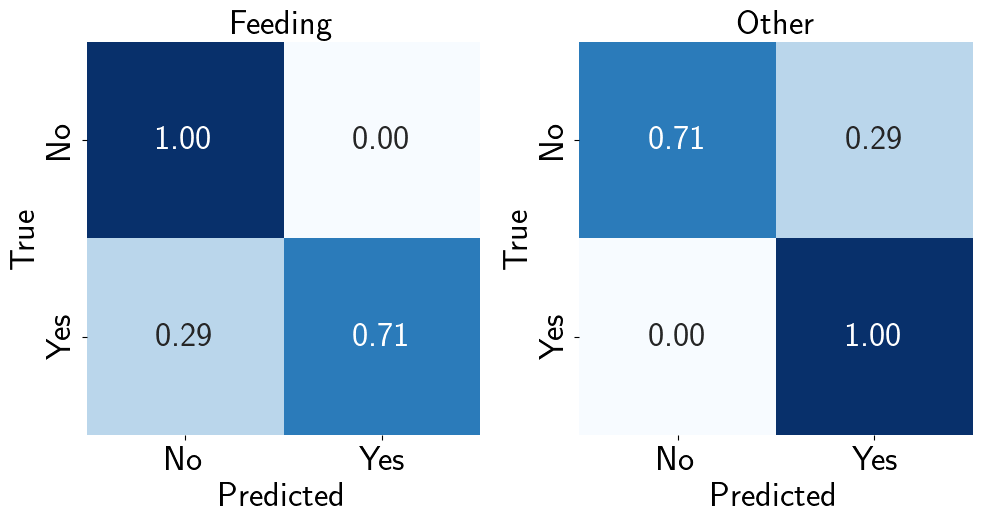

{}

In [51]:
theta_star, seed_star = 0.0, 1
model_dir = os.path.join(dir, f"theta{theta_star}_seed{seed_star}")
multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=True, return_precision=False)

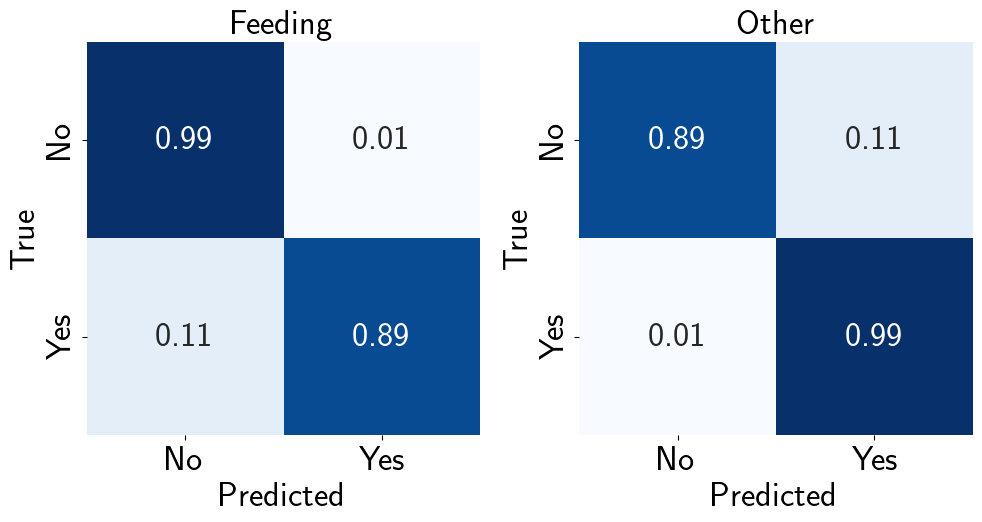

{}

In [52]:
theta_star, seed_star = 0.2, 1
model_dir = os.path.join(dir, f"theta{theta_star}_seed{seed_star}")
multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=True, return_precision=False)

In [53]:
multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=False, return_accuracy=True)


0.9929232444202504

## 3. Test the Model on Summaries on 20 seconds

In [38]:
acc_data_split = create_max_windows(acc_data=acc_data, window_duration=20.0, sampling_rate=config.SAMPLING_RATE)
acc_data_split = acc_data_split[acc_data_split.duration >= 20.0]
summary_acc_data_20 = create_summary_data(acc_data_split, sampling_rate=config.SAMPLING_RATE)

X = summary_acc_data_20[feature_cols].values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(summary_acc_data_20['behavior'])

In [39]:
window_duration_star, theta_star = 30.0, 0.4
model_dir = os.path.join(training_results_dir, f"duration{window_duration_star}_theta{theta_star}_seed{seed_star}")
model = torch.load(os.path.join(model_dir, 'model.pt'), weights_only=False).to(device)

In [40]:
with torch.no_grad():
    y_pred = torch.argmax(model(torch.tensor(X, dtype=torch.float32).to(device)), dim=1)

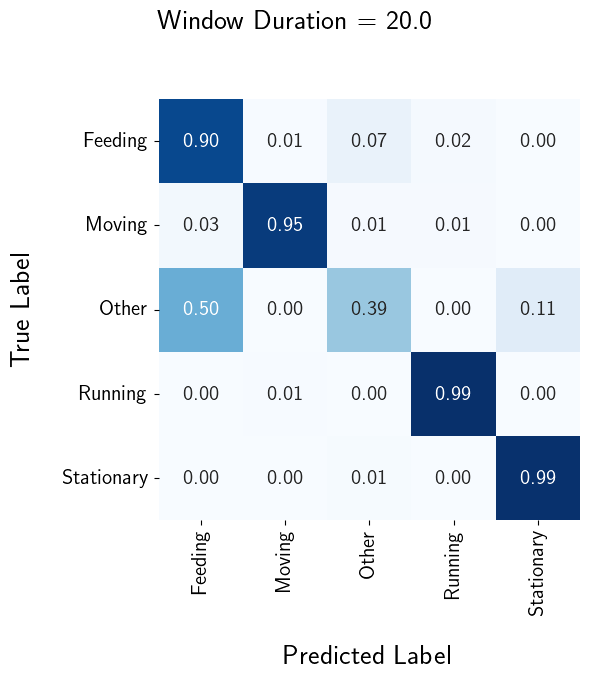

In [41]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 7))

cm = confusion_matrix(y, y_pred.detach().cpu().numpy(), normalize='true')
class_names = label_encoder.inverse_transform(np.arange(len(np.unique(y))))

sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, square=True, linewidths=0,
            annot_kws={"size": 15}, ax=ax)

ax.set_xlabel("Predicted Label", fontsize=20, labelpad=20)
ax.set_ylabel("True Label", fontsize=20, labelpad=20)
ax.set_xticklabels(class_names, fontsize=15, rotation=90)
ax.set_yticklabels(class_names, fontsize=15, rotation=0)
fig.suptitle(f"Window Duration = 20.0", fontsize=20)
plt.tight_layout()
plt.show()

## 4. Model Calibration

In [19]:
# pip install scikit-learn POT
import ot

def ot_plan(cost, a=None, b=None, reg=0.1):
    
    if a is None: a = np.full(cost.shape[0], 1.0/cost.shape[0])
    if b is None: b = np.full(cost.shape[1], 1.0/cost.shape[1])

    T = ot.sinkhorn(a, b, cost, reg=reg)
    return T, a, b

In [21]:
# load model
window_duration_star, theta_star = 30.0, 0.4
model_dir = os.path.join(training_results_dir, f"duration{window_duration_star}_theta{theta_star}_seed{seed_star}")
model = torch.load(os.path.join(model_dir, 'model.pt'), weights_only=False).to(device)

In [22]:
with torch.no_grad():
    y_test_scores = model(torch.tensor(X_test, dtype=torch.float32).to(device))

y_test_scores = y_test_scores.cpu().numpy()
y_test_pred = np.argmax(y_test_scores, axis=1)

In [ ]:
from collections import Counter
counts_pred = Counter(y_test_pred)
counts_test = Counter(y_test)
counts_val = Counter(y_val)

total = len(y_test_pred)

print("CLASS DISTRIBUTION IN VAL DATA")
print('-'*20)
for cls, count in counts_val.items():
    print(f"{label_encoder.inverse_transform([cls])}: {100*count/total:.2f}")
print("")

print("CLASS DISTRIBUTION IN TEST DATA")
print('-'*20)
for cls, count in counts_test.items():
    print(f"{label_encoder.inverse_transform([cls])}: {100*count/total:.2f}")
print("")

print("PREDICTED CLASS DISTRIBUTION IN TEST DATA")
print('-'*20)
for cls, count in counts_pred.items():
    print(f"{label_encoder.inverse_transform([cls])}: {100*count/total:.2f}")

CLASS DISTRIBUTION IN VAL DATA
--------------------
['Stationary']: 80.97
['Feeding']: 4.58
['Running']: 5.17
['Moving']: 9.03
['Other']: 0.26

CLASS DISTRIBUTION IN TEST DATA
--------------------
['Stationary']: 80.97
['Moving']: 9.03
['Feeding']: 4.51
['Running']: 5.23
['Other']: 0.26

PREDICTED CLASS DISTRIBUTION IN TEST DATA
--------------------
['Stationary']: 80.25
['Moving']: 8.63
['Feeding']: 4.64
['Running']: 5.30
['Other']: 1.18


In [39]:
# calibrate the predictions on test set to follow the true class distribution (on validation set)

b = np.array([counts_val[i] for i in range(len(config.SUMMARY_BEHAVIORS))])/y_val.shape[0]
T, a, b = ot_plan(1-y_test_scores, a=None, b=b, reg=0.01)
ot_pred = np.argmax(T, axis=1)

/home/medhaaga/miniconda3/envs/wildlife/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


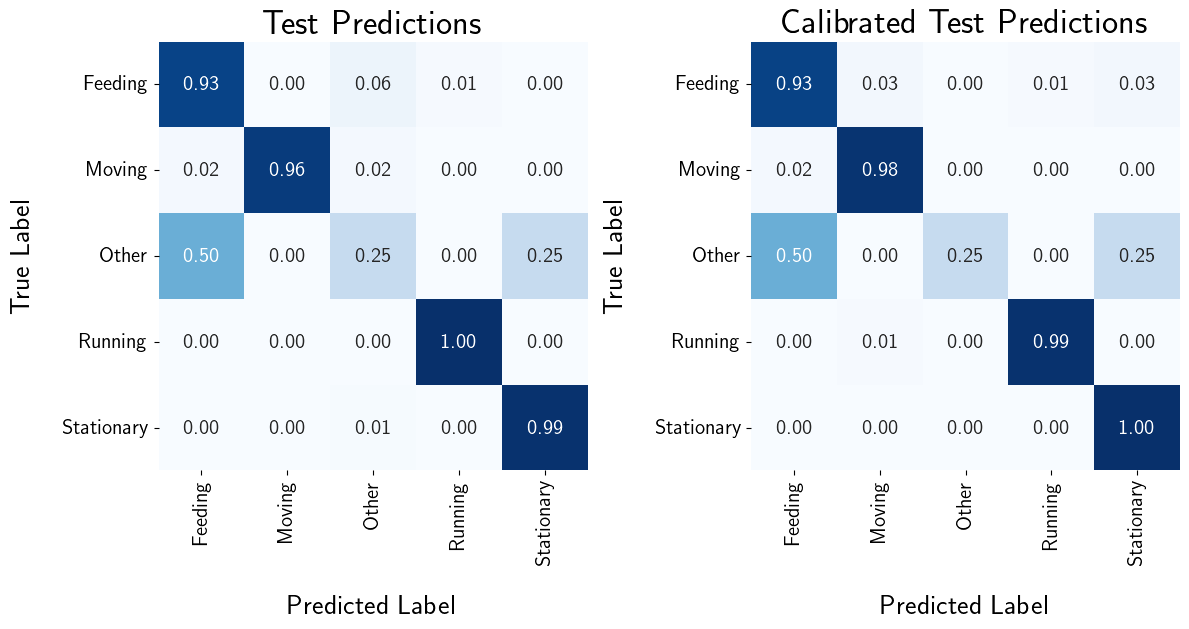

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(12, 7))

cm = confusion_matrix(y_test, y_test_pred, normalize='true')
class_names = label_encoder.inverse_transform(np.arange(len(np.unique(y_test))))
ax = axes[0]
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, square=True, linewidths=0,
            annot_kws={"size": 15}, ax=ax)

ax.set_xlabel("Predicted Label", fontsize=20, labelpad=20)
ax.set_ylabel("True Label", fontsize=20, labelpad=20)
ax.set_xticklabels(class_names, fontsize=15, rotation=90)
ax.set_yticklabels(class_names, fontsize=15, rotation=0)
ax.set_title("Test Predictions")

cm = confusion_matrix(y_test, ot_pred, normalize='true')
class_names = label_encoder.inverse_transform(np.arange(len(np.unique(y_test))))
ax = axes[1]

sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, square=True, linewidths=0,
            annot_kws={"size": 15}, ax=ax)

ax.set_xlabel("Predicted Label", fontsize=20, labelpad=20)
ax.set_ylabel("True Label", fontsize=20, labelpad=20)
ax.set_xticklabels(class_names, fontsize=15, rotation=90)
ax.set_yticklabels(class_names, fontsize=15, rotation=0)
ax.set_title("Calibrated Test Predictions")

plt.tight_layout()
plt.show()

In [ ]:
print(np.sum(y_test != ot_pred), np.sum(y_test != y_test_pred))

15 26


In [47]:
classes, counts = np.unique(label_encoder.inverse_transform(y_test), return_counts=True)
for cls, count in zip(classes, counts):
    print(f"{cls}: {count}")

Feeding: 69
Moving: 138
Other: 4
Running: 80
Stationary: 1238


In [45]:
classes, counts = np.unique(label_encoder.inverse_transform(y_test[y_test != y_test_pred]), return_counts=True)
for cls, count in zip(classes, counts):
    print(f"{cls}: {count}")

Feeding: 5
Moving: 6
Other: 3
Stationary: 12


In [46]:
classes, counts = np.unique(label_encoder.inverse_transform(y_test[y_test != ot_pred]), return_counts=True)
for cls, count in zip(classes, counts):
    print(f"{cls}: {count}")

Feeding: 5
Moving: 3
Other: 3
Running: 1
Stationary: 3
